In [39]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionPipeline, StableDiffusionDiffEditPipeline, DDIMScheduler, DDIMInverseScheduler

from pipeline_stable_diffusion_radedit import StableDiffusionRadEditPipeline

In [43]:
# model_path = "/vol/biomedic3/rrr2417/roentgen/roentgen"
model_path = "runwayml/stable-diffusion-v1-5"

# cxr_target_prompt = "Moderate pulmonary oedema. The heart size is normal."
cxr_target_prompt = "Left pectoral pacemaker in place. The position of the leads is as expected. Otherwise unremarkable chest radiographic examination."
# cxr_target_prompt = "New left upper lobe consolidation."
# cxr_target_prompt = "New right upper lobe consolidation."

params_dict = {
    "/vol/biomedic3/rrr2417/roentgen/roentgen": {
        "image_path": "cxr_1.jpg",
        "source_prompt": "Normal chest radiograph. Specifically, no evidence of pneumonia.",
        "target_prompt": cxr_target_prompt,
        "size": (512, 512),
    },
    # "stabilityai/stable-diffusion-2-1": {
    "runwayml/stable-diffusion-v1-5": {
        # "image_path": "fruit.jpg",
        # "source_prompt": "A bowl of fruits",
        # "target_prompt": "A bowl of pears",
        # "size": (768, 768),
        "image_path": "cat_mirror.jpeg",
        "source_prompt": "A photo of an unknown object",
        "target_prompt": "A photo of a airplane",
        "size": (768, 768),
    },
}
params = params_dict[model_path]

In [44]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

init_image = Image.open(params["image_path"]).convert("RGB").resize(params["size"])

In [45]:
torch_dtype = torch.float16

pipeline = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=torch_dtype,
    safety_checker=None,
).to(device)

pipeline_diffedit = StableDiffusionDiffEditPipeline.from_pretrained(
    model_path,
    torch_dtype=torch_dtype,
    safety_checker=None,
).to(device)
pipeline_diffedit.scheduler = DDIMScheduler.from_config(pipeline_diffedit.scheduler.config)
pipeline_diffedit.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline_diffedit.scheduler.config)
pipeline_diffedit.enable_model_cpu_offload()

pipeline_radedit = StableDiffusionRadEditPipeline.from_pretrained(
    model_path,
    torch_dtype=torch_dtype,
    safety_checker=None,
).to(device)
pipeline_radedit.scheduler = DDIMScheduler.from_config(pipeline_radedit.scheduler.config)
pipeline_radedit.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline_radedit.scheduler.config)
pipeline_radedit.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion_diffedit.pipeline_stable_diffusion_diffedit.StableDiffusionDiffEditPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'pipeline_stable_diffusion_radedit.StableDiffusionRadEditPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [46]:
source_prompt = params["source_prompt"]
target_prompt = params["target_prompt"]

guidance_scale = 7.5

def _edit_image(pipeline, init_image, source_prompt, target_prompt, guidance_scale):
    mask_image = pipeline.generate_mask(
        image=init_image,
        source_prompt=source_prompt,
        target_prompt=target_prompt,
    )
    image_latents = pipeline.invert(
        image=init_image,
        prompt=source_prompt,
    ).latents
    edited_image = pipeline(
        mask_image=mask_image,
        prompt=target_prompt,
        image_latents=image_latents,
        guidance_scale=guidance_scale,
    ).images[0]
    return mask_image, edited_image

# generation
generated_image = pipeline(prompt=target_prompt, guidance_scale=guidance_scale).images[0]

# diffedit
mask_image_d, edited_image_d = _edit_image(pipeline_diffedit, init_image, source_prompt, target_prompt, guidance_scale)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [47]:
threshold = 250

def _diff_map(init_image, edited_image, threshold):
    diff_map = np.abs(np.array(init_image) - np.array(edited_image)).mean(axis=2)
    diff_map = (diff_map > threshold).astype(np.uint8)
    diff_map = Image.fromarray(255 - (diff_map * 255))
    return diff_map

diff_map_r = _diff_map(init_image, edited_image_r, threshold)
diff_map_d = _diff_map(init_image, edited_image_d, threshold)

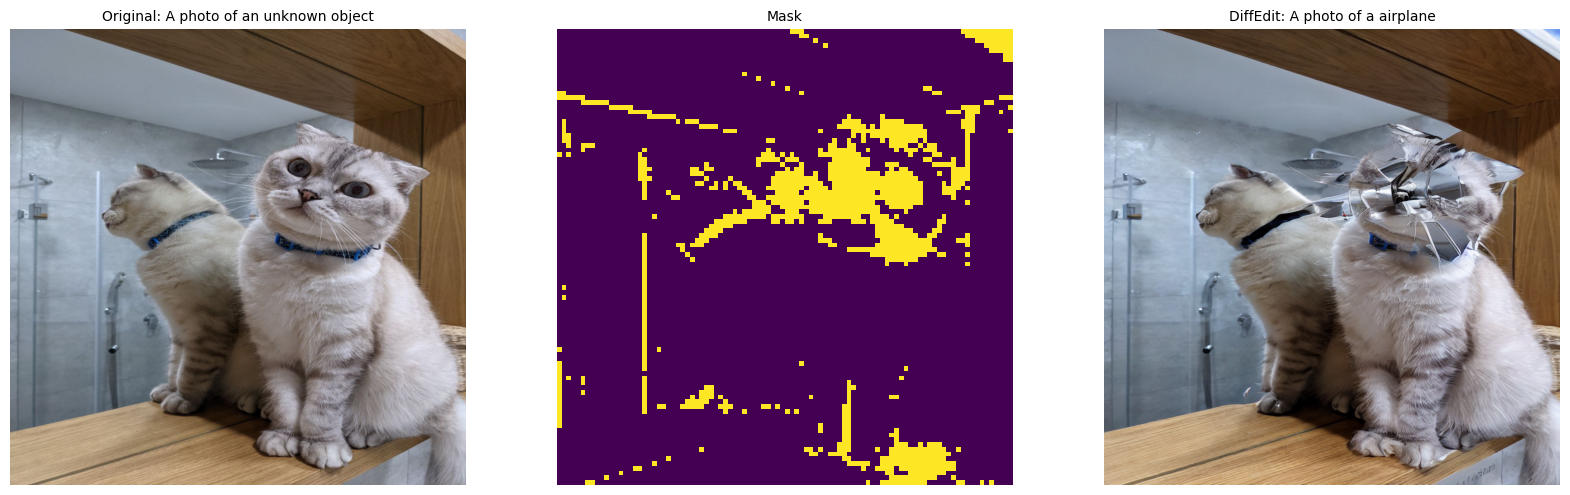

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 40))

def _plot_on_axis(ax, image, title):
    ax.imshow(image)
    ax.set_title(title, fontsize=10)
    ax.axis("off")

def rgb_to_grayscale(image):
    t = torch.tensor(np.array(image))
    g = t[:, :, 0] * 0.3 + t[:, :, 1] * 0.59 + t[:, :, 2] * 0.11
    print(g.shape)
    return Image.fromarray(np.uint8(g)).convert("L")

_mask_image = (mask_image_d.transpose(1, 2, 0) * 255).squeeze(axis=-1).astype(np.uint8)
_mask_image = Image.fromarray(_mask_image)

_plot_on_axis(ax[0], init_image, f"Original: {source_prompt}")
_plot_on_axis(ax[1], _mask_image, "Mask")
_plot_on_axis(ax[2], edited_image_d, f"DiffEdit: {target_prompt}")

plt.show()